# Przeanalizowanie danych z ostatnich lat Serie A oraz wykorzystać ich do przewidywania ich potencjalnego rozwoju w następnym sezonie.

In [4]:
import os

from ipywidgets import widgets
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mpldatacursor
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
# Nazwy do zapisów
FILENAME_DATA = 'dataset-multiyear.csv'

%matplotlib notebook
sns.set()

## Ładowanie i selekcja cech

Dataset jest to zbiór statystyk z 4 sezonów Serie A (via Fantagazzetta), zawierający również ocenę jego gry według ekspertów oraz użytkowników. 

In [27]:
# Wczytywanie bazy
filepath_data = os.path.join(FILENAME_DATA)
df = pd.read_csv(filepath_data)

Usuwamy zawodników którzy rozegrali mniej niż 10 meczy w ostatnim sezonie. Powodem jest za mała próbka.

In [36]:
N_MIN_GAMES = 10
df = df[df['Pg1617'] > N_MIN_GAMES]

Ustale jeszcze by zawownicy przez 2 ostatnie sezony grali w Serie A oraz by pominąć wyniki zerowe. 

In [37]:
cols_mf = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
idxs_to_remove_last_seasons = df[cols_mf[-2:]].isnull().any(axis=1)  # sprawdzenie gry w osatnich sezonach
idxs_to_remove_zeros = df[cols_mf[-1]] == 0  # oceny równe 0, by pominąć błędne informacje w danych
idxs_to_remove = idxs_to_remove_last_seasons| idxs_to_remove_zeros
df_updated = df[~idxs_to_remove]

# Preview data
df_updated.head()
#print (len(df_updated))

,Name,Yc1314,Yc1415,Yc1516,Yc1617,Ass1516,Ass1617,Asr1314,Asr1415,Asr1516,...,Pk1516,Pk1617,Ps1314,Ps1415,Ps1516,Ps1617,Team1314,Team1415,Team1516,Team1617
0,ABATE,1.0,5.0,7.0,2.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,MILAN,MILAN,Milan,Milan
2,ACERBI,1.0,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,SASSUOLO,SASSUOLO,Sassuolo,Sassuolo
5,ACQUAH,6.0,9.0,9.0,2.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,PARMA,SAMPDORIA,Torino,Torino
8,ADNAN,NaN,NaN,6.0,2.0,0.0,0.0,NaN,NaN,1.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,Udinese,Udinese
17,ALBIOL,5.0,10.0,10.0,8.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NAPOLI,NAPOLI,Napoli,Napoli


Powyższych warunków nie spełnia 104 zawodników.

Całkowita liczba danych wynosi 265 zawodników. Biorąc pod uwagę spadki oraz awanse drużyn z ligi, jak również transfery zawodników z/do lig zagranicznych, liczba próbek wygląda sensownie.  

# Trendy w danych

Zawodnicy o stałym rozwoju przez kolejne sezony. 

In [38]:
COLS_TRENDS = ['Name', 
               'Delta1', 'Delta2', 'Delta3', 
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']

data_progres_trend = []
for id_player in df_updated.index:  
    player = df_updated.loc[id_player]
    # Obliczenia róźnicy między oceną poszczególnych sezonów
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  # delta == 0 dla braku danych
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in range(len(curr_mf) - 1)])
    n_negative_deltas = sum(np.array(curr_deltas) < 0) #sprawdzenie
    if n_negative_deltas == 0:
        # nowy dataset
        row = [player['Name']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_progres_trend.append(row)

df_progres_trend = pd.DataFrame(data=data_progres_trend, 
                                 columns=COLS_TRENDS)
print ("Liczba zawodników z zauważalnym progresie:", len(df_progres_trend))
df_progres_trend.head()

Liczba zawodników z zauważalnym progresie: 58


,Name,Delta1,Delta2,Delta3,Sf1314,Sf1415,Sf1516,Sf1617
0,ANTEI,0.19,0.09,0.13,5.52,5.71,5.80,5.93
1,BABACAR,0.00,0.10,0.37,NaN,7.08,7.18,7.55
2,BADELJ,0.00,0.27,0.10,NaN,5.71,5.98,6.08
3,BALOGH,0.00,0.00,0.27,NaN,NaN,5.00,5.27
4,BARRETO E,0.00,0.00,0.51,NaN,NaN,5.57,6.08


<IPython.core.display.Javascript object>


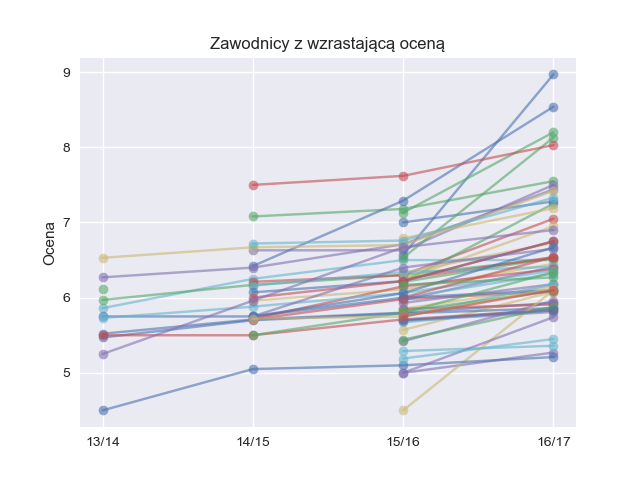

In [39]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']
#names = ['DZEKO',
#          'BELOTTI',
#          'SZCZESNY']
names = []

if len(names) > 0:
    data = df_progres_trend[df_progres_trend['Name'].isin(names)]
    data = data.sort_values(['Sf1617'], ascending=False)
    names = data['Name'].values
    data = data.values[:, 4:]
else:
    data = df_progres_trend.values[:, 4:]

fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_progres_trend.iloc[i_row, :]['Name']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
# Wykorzystanie kursora do sprawdzenia zawodnika
mpldatacursor.datacursor(formatter='{label}'.format)

# Wykres
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z wzrastającą oceną')
plt.ylabel('Ocena')
if len(names) > 0:
    plt.legend()

Zawodników ze stałym rozwojem jest 58, w znacznej większości są to zawodnicy ofensywni. W zestawieniu znajdują się co ciekawe 5 bramkarzy. 

Zawodnicy którzy regularnie zaliczyli regres.

In [40]:
COLS_TRENDS = ['Name', 
               'Delta1', 'Delta2', 'Delta3', 
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']

data_regres_trend = []
for id_player in df_updated.index:  
    player = df_updated.loc[id_player]
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in range(len(curr_mf) - 1)])
    n_progres_deltas = sum(np.array(curr_deltas) > 0)
    if n_progres_deltas == 0:
        row = [player['Name']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_regres_trend.append(row)
        
df_regres_trend = pd.DataFrame(data=data_regres_trend, 
                                 columns=COLS_TRENDS)
print ("Number of players with regres trend:", len(df_regres_trend))
df_regres_trend.head()

Number of players with regres trend: 46


,Name,Delta1,Delta2,Delta3,Sf1314,Sf1415,Sf1516,Sf1617
0,ADNAN,0.0,0.0,-0.51,NaN,NaN,6.05,5.54
1,ALEX SANDRO,0.0,0.0,-0.32,NaN,NaN,6.74,6.42
2,ALVAREZ R,0.0,0.0,-0.10,NaN,NaN,6.19,6.09
3,ANSALDI,0.0,0.0,-0.48,NaN,NaN,6.10,5.62
4,BACCA,0.0,0.0,-0.67,NaN,NaN,7.54,6.87


<IPython.core.display.Javascript object>


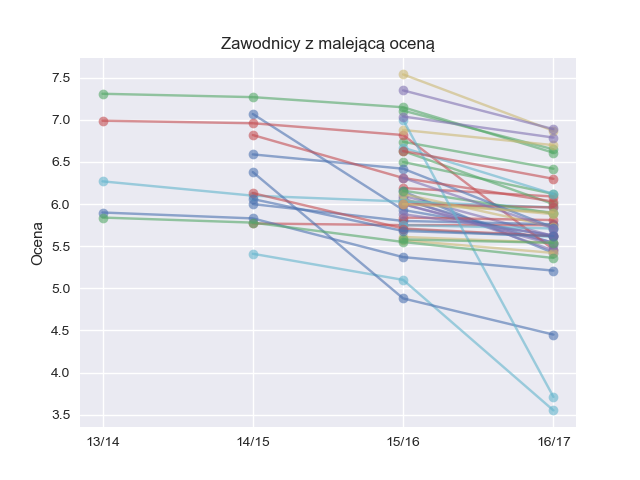

In [42]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']

names = []

if len(names) > 0:
    data = df_regres_trend[df_regres_trend['Name'].isin(names)]
    data = data.sort_values(['Sf1617'], ascending=False)
    names = data['Name'].values
    data = data.values[:, 4:]
else:
    data = df_regres_trend.values[:, 4:]

fig, ax = plt.subplots()
for i_row, row in enumerate(data):
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_regres_trend.iloc[i_row, :]['Name']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z malejącą oceną')
plt.ylabel('Ocena')
if len(names) > 0:
    plt.legend()

46 zawodników przyjmujących stały regres formy. Większość to zawodnicy z formacji obronnej oraz zawodnicy już u schyłku kariery.

# Różnica między pierwszym sezonem gry a ostatnim.

By zneutralizować działanie wachań formy (słabszy sezon zawodnika), obliczam różnicę między pierwszym a ostatnim sezonem 
zawodnika.

In [51]:
COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_DELTAS = ['Name', 'Delta', 'Squadra1617',
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
data_deltas = []
for id_player in df_updated.index: 
    player = df_updated.loc[id_player]
    curr_mf = player[COLS_MF].dropna()
    curr_delta = curr_mf[-1] - curr_mf[0]
    # Stworzenie dataset
    row = [player['Name']]
    row.append(curr_delta)
    row.append(player['Team1617'])
    row.extend(player[COLS_MF])
    data_deltas.append(row)
    
df_deltas = pd.DataFrame(data=data_deltas, columns=COLS_DELTAS)
df_deltas = df_deltas.sort_values(['Delta'],ascending=False)  # sortowanie
df_deltas.head()

,Name,Delta,Squadra1617,Sf1314,Sf1415,Sf1516,Sf1617
88,DZEKO,2.40,Roma,NaN,NaN,6.57,8.97
23,BELOTTI,2.12,Torino,NaN,6.42,7.29,8.54
175,MERTENS,1.95,Napoli,7.43,6.48,6.67,9.38
131,INSIGNE,1.92,Napoli,6.38,6.34,7.45,8.30
263,ZIELINSKI,1.65,Napoli,5.25,5.96,6.67,6.90


Wykres z najorszą róźnicą.

<IPython.core.display.Javascript object>


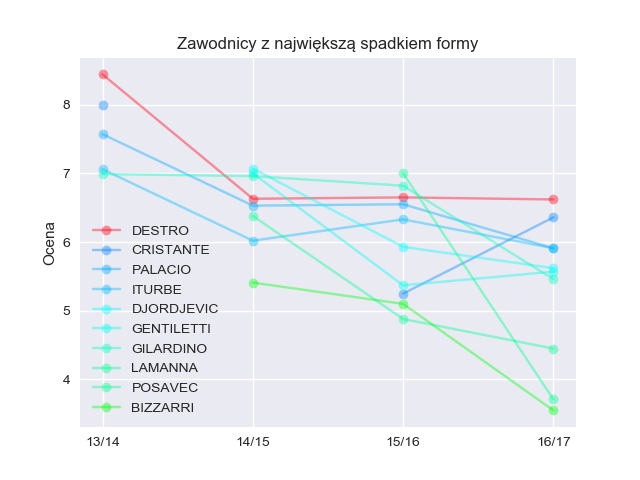

In [44]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']

# Warunku
N = 10
df_deltas_worst = df_deltas.iloc[:N, :]
data = df_deltas_worst.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 3:]
delta_min = df_deltas_worst['Delta'].min()

# Wykres
fig, ax = plt.subplots()
for i_row, row in enumerate(data): 
    curr_delta = df_deltas_worst.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(abs(curr_delta / delta_min))
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)

mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z największą spadkiem formy')
plt.ylabel('Ocena')
plt.legend()

<IPython.core.display.Javascript object>


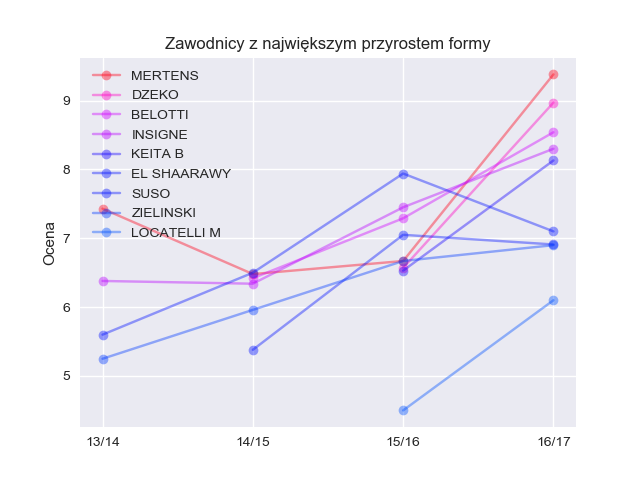

In [45]:

X_TICKS = ['13/14', '14/15', '15/16', '16/17']

# Dane
N = 10 
df_deltas_best = df_deltas.iloc[range(len(df_deltas)-1, len(df_deltas)-N, -1), :]
data = df_deltas_best.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 3:]
delta_max = df_deltas_best['Delta'].max()

# Wykres
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    curr_delta = df_deltas_best.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(curr_delta / delta_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z największym przyrostem formy')
plt.ylabel('Ocena')
plt.legend()

# Oszacowanie ratingu zawodnika na podstawie średniej ze wszystkich sezonów.

In [53]:
COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_MEANS = ['Name', 'Mean', 'Squadra1617', 'R1617',
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
data_means = []
for id_player in df_updated.index:  
    player = df_updated.loc[id_player]
    # Obliczanie średniej
    curr_mf = player[COLS_MF].dropna()
    curr_mean = np.mean(curr_mf)
    # Tworzenie dataset
    row = [player['Name']]
    row.append(curr_mean)
    row.append(player['Team1617'])
    row.append(player['R1617'])
    row.extend(player[COLS_MF])
    data_means.append(row)
    
df_means = pd.DataFrame(data=data_means, columns=COLS_MEANS)
df_means = df_means.sort_values(['Mean'],ascending=True)  
df_means.head(10)

,Name,Mean,Squadra1617,R1617,Sf1314,Sf1415,Sf1516,Sf1617
216,RAFAEL,4.600000,Cagliari,G,4.46,4.72,4.08,5.14
32,BIZZARRI,4.686667,Pescara,G,NaN,5.41,5.10,3.55
236,SORRENTINO,4.713333,Chievo,G,NaN,4.74,4.69,4.71
70,DA COSTA,4.750000,Bologna,G,4.50,NaN,5.00,4.75
139,KARNEZIS,4.793333,Udinese,G,NaN,5.05,4.63,4.70
245,TATARUSANU,4.800000,Fiorentina,G,NaN,4.78,5.05,4.57
178,MIRANTE,4.812500,Bologna,G,5.07,4.29,5.18,4.71
60,CONSIGLI,4.950000,Sassuolo,G,4.97,4.69,5.22,4.92
234,SKORUPSKI,4.950000,Empoli,G,5.75,4.33,4.79,4.93
163,MARCHETTI,4.965000,Lazio,G,4.50,5.05,5.10,5.21


Zawodnicy z najgorszą średnią.

<IPython.core.display.Javascript object>


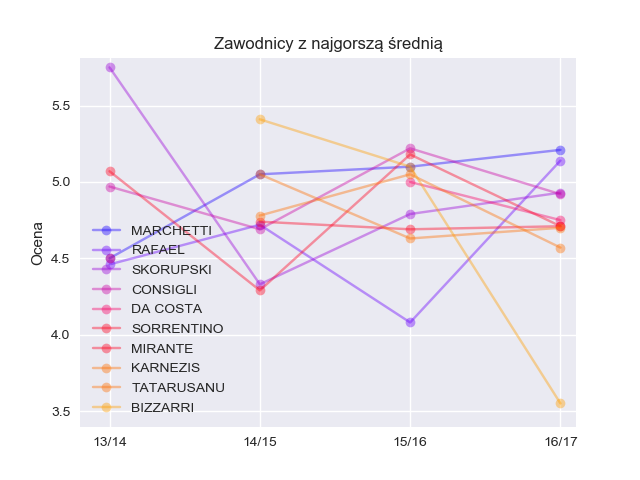

In [47]:
X_TICKS  = ['13/14', '14/15', '15/16', '16/17']

N = 10
df_means.iloc[:N, :]

N = 10
df_means_worst = df_means.iloc[:N, :]
data = df_means_worst.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 4:]
mean_max = df_means['Mean'].max()

fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    curr_mean = df_means_worst.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z najgorszą średnią')
plt.ylabel('Ocena')
plt.legend()

Wszyscy z zawodników to bramkarze, spowodowane jest to brakiem strzelonych bramek czy asyst które podwyższają ocenę.

Zawodnicy z najwyższą średnią.

<IPython.core.display.Javascript object>


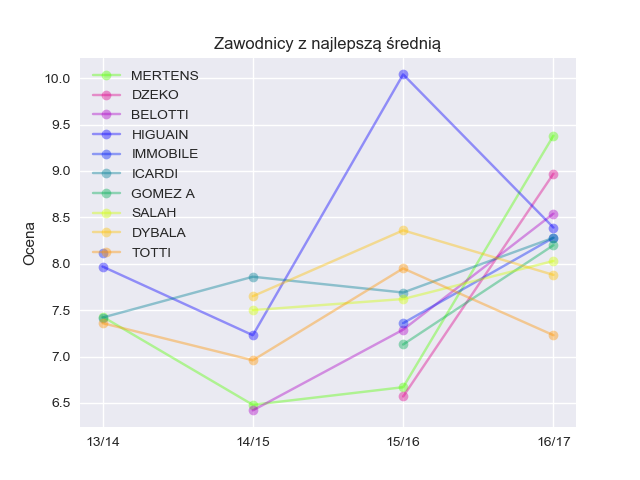

In [48]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']

N = 10 + 1
df_means_best = df_means.iloc[range(len(df_means)-1, len(df_means)-N, -1), :]
data = df_means_best.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 4:]
mean_max = df_means_best['Mean'].max()

# Wykres
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    curr_mean = df_means_best.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z najlepszą średnią')
plt.ylabel('Ocena')
plt.legend()

Tutaj zawodnicy to napastnicy. Teraz sprawdzenie ze względu na pozycje na boisku.

<IPython.core.display.Javascript object>


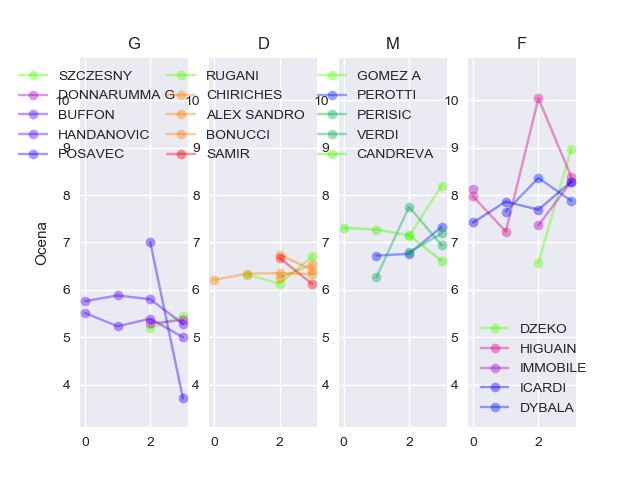

In [49]:
#Pozycje
pozycje = ['G', 'D', 'M', 'F']
X_TICKS = ['13/14', '14/15', '15/16', '16/17']
N = 5 + 1

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax = (ax1, ax2, ax3, ax4)

for (i_pozycja, pozycja) in enumerate(pozycje):  
    
    df_means_pozycja = df_means[df_means['R1617'] == pozycja]
    df_means_best_pozycja = df_means_pozycja.iloc[range(len(df_means_pozycja)-1, len(df_means_pozycja)-N, -1), :]
    data = df_means_best_pozycja.sort_values(['Sf1617'], ascending=False)
    labels = data['Name'].values
    data = data.values[:, 4:]
    mean_max = df_means_best_pozycja['Mean'].max()

    for i_row, row in enumerate(data):  
        curr_mean = df_means_best_pozycja.iloc[i_row, :]['Mean']
        curr_label = labels[i_row]
        curr_col = cm.prism(curr_mean / mean_max)
        ax[i_pozycja].plot(row, marker='o', 
                        c=curr_col, alpha=0.4,
                        label=curr_label)

    mpldatacursor.datacursor(formatter='{label}'.format)

    ax[i_pozycja].set_xticks(range(len(X_TICKS)), X_TICKS)
    ax[i_pozycja].set_title(pozycja)
    if i_pozycja == 0:
        ax[i_pozycja].set_ylabel('Ocena')
    ax[i_pozycja].legend()
    ax[i_pozycja].set_ylim([3.1, 10.9])

Przykłady Posaveca oraz Higuaina pokazują, że wystarczy jeden sezon zdecydowanie ponad możliwości by znaleźć się w czołówce.

# Najlepsi w przyszłym sezonie

Wykorzystując wcześniejsze obliczenia, tworzymy wskażniki ,,mocy" zawodnika by dobrać takich - którzy z największym prawdopodobieństwem będą kluczowymi zawodnikami w kolejnym sezonie.

Korzystamy z parametrów:

-Ocena różnicy między pierwszym a ostatnim sezonem.

-Rating z kariery.

-Przyrost/Regres formy.

-Liczba lat gry w Serie A.

-Średnia ocena z ostatniego sezonu.

Prosta formuła może pomóc w przybliżeniu wydajności każdego pojedynczego gracza w następnym sezonie Serie A. Oblicza następującą sumę ważoną:


Wybierając różne wagi, można nadać mniej lub bardziej istotne znaczenie określonym aspektom kariery piłkarza.

Formuła zwraca wynik na przyszły sezon. Wartości są sortowane od najlepszych zawodników.

In [55]:
def _sort_players_by_weighted_score(df, w_d, w_m, w_t, w_y, role=''):
    # Constants
    COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
    COLS_REDUX = ['Name', 'R1617', 'Team1617', 'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
    COLS_WEIGHTS = ['Name', 'R1617', 'Team1617', 'Sf1617',
                    'WeightedScore', 'DeltaScore', 'MeanScore', 'TrendScore', 'YearsScore']
    # Filtr Danych
    df_redux = df[COLS_REDUX]
    data_full = []
    
    if len(role) > 0:
        df_redux = df_redux[df_redux['R1617'] == role]
    data_weight_score = []
    for id_player in df_redux.index:  
        player = df_redux.loc[id_player]
        name = player['Name']
        
        # Obliczanie wagi
        score = df_redux['Sf1617'].values[0]
        score_d = w_d * df_deltas[df_deltas['Name'] == name]['Delta'].values[0]
        score_m = w_m * df_means[df_means['Name'] == name]['Mean'].values[0]
        score_t = 0
        if name in df_progres_trend['Name'].values:
            score_t = w_t
        curr_mf = player[COLS_MF].dropna()
        score_y = w_y * len(curr_mf)
        score_weighted = score + score_d + score_m + score_t + score_y
        # Dodanie dataset
        row = [name]
        row.append(player['R1617'])
        row.append(player['Team1617'])
        row.append(player['Sf1617'])
        row.append(score_weighted)
        row.extend([score_d, score_m, score_t, score_y])
        data_weight_score.append(row)
        data_full.append(row)
   
    df_weight_scores = pd.DataFrame(data=data_weight_score, 
                                    columns=COLS_WEIGHTS)
    df_weight_scores = df_weight_scores.sort_values(['WeightedScore'])
    
    df_full = pd.DataFrame(data=data_full, columns=COLS_WEIGHTS)
    df_full = df_full.sort_values(['WeightedScore'])  
    return df_weight_scores

In [62]:
from IPython.display import clear_output
plt.style.use('ggplot')

#Okienko
WIDTH_TEXT = 50
text_delta = widgets.FloatText(description="Różnica Weight", 
                          value="0.8",
                          width=WIDTH_TEXT)
text_mean = widgets.FloatText(description="Średnia Weight", 
                          value="0.7",
                          width=WIDTH_TEXT)
text_trend = widgets.FloatText(description="Trend Weight", 
                          value="1.0",
                          width=WIDTH_TEXT)
text_years = widgets.FloatText(description="Wiek Weight", 
                          value="0.8",
                          width=WIDTH_TEXT)
display(text_delta)
display(text_mean)
display(text_trend)
display(text_years)

# POZYCJE
dropdown_role =  widgets.Dropdown(
    options=['G', 'D', 'M', 'F', 'All'],
    value='F',
    description='Role:',
    disabled=False,
)
display(dropdown_role)

# Przycisk
button_calculate = widgets.Button(description="Oblicz")
display(button_calculate)
def on_button_clicked(b):
    # Wartości
    w_d = float(text_delta.value)
    w_m = float(text_mean.value)
    w_t = float(text_trend.value)
    w_y = float(text_years.value)
    role = dropdown_role.value
    if len(role) != 1:
        role = ''
    # Najlepsi zawodnicy
    N = 10
    df_weighted_scores = _sort_players_by_weighted_score(df_updated, 
                                                         w_d, w_m, w_t, w_y, role)
    clear_output()
    #df_updated.names = ['DZEKO']
    
    print (df_weighted_scores.iloc[range(len(df_weighted_scores)-1, 
                                        len(df_weighted_scores)-N, -1), :])

        
button_calculate.on_click(on_button_clicked)

           Name R1617   Team1617  Sf1617  WeightedScore  DeltaScore  \
3       BELOTTI     F     Torino    8.54      17.837667       1.696   
36      MERTENS     F     Napoli    9.38      17.553000       1.560   
11        DZEKO     F       Roma    8.97      17.509000       1.920   
37       MURIEL     F  Sampdoria    7.44      17.379500       0.936   
23      INSIGNE     F     Napoli    8.30      17.268250       1.536   
18      HIGUAIN     F   Juventus    8.39      16.971250       0.336   
20       ICARDI     F      Inter    8.28      16.906750       0.688   
48        SALAH     F       Roma    8.03      16.775667       0.424   
13  EL SHAARAWY     F       Roma    7.10      16.699500       1.200   

    MeanScore  TrendScore  YearsScore  
3    5.191667         1.0         2.4  
36   5.243000         0.0         3.2  
11   5.439000         1.0         1.6  
37   4.693500         1.0         3.2  
23   4.982250         0.0         3.2  
18   5.885250         0.0         3.2  
20   5.46

In [137]:
COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_REDUX = ['Name', 'R1617', 'Team1617', 'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_WEIGHTS = ['Name', 'R1617', 'Team1617', 'Sf1617',
                    'WeightedScore', 'DeltaScore', 'MeanScore', 'TrendScore', 'YearsScore']
# Filtr Danych
df_redux = df_updated[COLS_REDUX]
if len(role) != 1:
    role = ''
#role = 'All'
if len(role) > 0:
    df_redux = df_redux[df_redux['R1617'] == role]
data_weight_score = []
    
# wagi
#w_d = 0.8
#w_m = 0.7
#w_t = 1
#w_y = 0.8


for id_player in df_redux.index:  
    player = df_redux.loc[id_player]
    name = player['Name']
        
    # Obliczanie wagi
    score = df_redux['Sf1617'].values[0]
    score_d = 0.8 * df_deltas[df_deltas['Name'] == name]['Delta'].values[0]
    score_m = 0.7 * df_means[df_means['Name'] == name]['Mean'].values[0]
    score_t = 0
    if name in df_progres_trend['Name'].values:
        score_t = 1
    curr_mf = player[COLS_MF].dropna()
    score_y = 0.8 * len(curr_mf)
    score_weighted = score + score_d + score_m + score_t + score_y
    # Dodanie dataset
    row = [name]
    row.append(player['R1617'])
    row.append(player['Team1617'])
    row.append(player['Sf1617'])
    row.append(score_weighted)
    row.extend([score_d, score_m, score_t, score_y])
    data_weight_score.append(row)

    
df_weight_scores = pd.DataFrame(data=data_weight_score, 
                            columns=COLS_WEIGHTS)
df_weight_scores = df_weight_scores.sort_values(['WeightedScore'], ascending=False) 
df_weight_scores


#print (df_weighted_scores.iloc[range(len(df_weighted_scores)-1, len(df_weighted_scores)-N, -1), :])

,Name,R1617,Team1617,Sf1617,WeightedScore,DeltaScore,MeanScore,TrendScore,YearsScore
23,BELOTTI,F,Torino,8.54,16.217667,1.696,5.191667,1,2.4
175,MERTENS,F,Napoli,9.38,15.933000,1.560,5.243000,0,3.2
88,DZEKO,F,Roma,8.97,15.889000,1.920,5.439000,1,1.6
263,ZIELINSKI,M,Napoli,6.90,15.786500,1.320,4.336500,1,3.2
182,MURIEL,F,Sampdoria,7.44,15.759500,0.936,4.693500,1,3.2
131,INSIGNE,F,Napoli,8.30,15.648250,1.536,4.982250,0,3.2
185,NAINGGOLAN,M,Roma,7.42,15.623000,0.712,4.781000,1,3.2
122,HIGUAIN,F,Juventus,8.39,15.351250,0.336,5.885250,0,3.2
127,ICARDI,F,Inter,8.28,15.286750,0.688,5.468750,0,3.2
229,SALAH,F,Roma,8.03,15.155667,0.424,5.401667,1,2.4


In [138]:
df_weight_scores.to_csv('ml.csv', sep='\t', encoding='utf-8')

In [121]:
df_weight_scores['WeightedScore']<10

23     False
175    False
88     False
263    False
182    False
131    False
185    False
122    False
127    False
229    False
93     False
21     False
140    False
24     False
36     False
78     False
158    False
200    False
13     False
114    False
205    False
118    False
27     False
105    False
97     False
47     False
10     False
202    False
49     False
212    False
       ...  
226    False
236    False
123    False
65     False
142    False
145    False
230    False
177    False
245    False
83     False
169    False
104    False
82     False
139    False
211    False
62     False
109    False
166    False
183    False
222    False
115    False
9      False
57     False
3      False
144    False
113    False
42     False
148    False
32     False
209     True
Name: WeightedScore, Length: 265, dtype: bool

In [5]:
FILENAME_DATA = 'ML1.csv'
# Wczytywanie bazy
filepath_data = os.path.join(FILENAME_DATA)
dfML = pd.read_csv(filepath_data)

In [6]:
dfML.head()

,Sf1617,DeltaScore,MeanScore,TrendScore,YearsScore,Rating
0,8.54,1.696,5.191667,1,2.4,10
1,9.38,1.560,5.243000,0,3.2,9
2,8.97,1.920,5.439000,1,1.6,9
3,6.90,1.320,4.336500,1,3.2,9
4,7.44,0.936,4.693500,1,3.2,9


1. klasyfikować rezultaty od 1-10 i nauczyc i sprawdzic czy dobrze. 2. porównać rezultaty do śr. oceny

In [1]:
import pandas
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.svm import SVR
import numpy as np

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [7]:
X = dfML.iloc[:, 0:5]
y = dfML.iloc[:, 5]
X

,Sf1617,DeltaScore,MeanScore,TrendScore,YearsScore
0,8.54,1.696,5.191667,1,2.4
1,9.38,1.560,5.243000,0,3.2
2,8.97,1.920,5.439000,1,1.6
3,6.90,1.320,4.336500,1,3.2
4,7.44,0.936,4.693500,1,3.2
5,8.30,1.536,4.982250,0,3.2
6,7.42,0.712,4.781000,1,3.2
7,8.39,0.336,5.885250,0,3.2
8,8.28,0.688,5.468750,0,3.2
9,8.03,0.424,5.401667,1,2.4


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X

array([[ 0.85591767,  0.95079086,  0.739768  ,  1.        ,  0.5       ],
       [ 1.        ,  0.92091388,  0.75902823,  0.        ,  1.        ],
       [ 0.9296741 ,  1.        ,  0.8325673 ,  1.        ,  0.        ],
       ..., 
       [ 0.15437393,  0.23901582,  0.16721383,  0.        ,  0.5       ],
       [ 0.        ,  0.2513181 ,  0.02276209,  0.        ,  0.5       ],
       [ 0.02744425,  0.        ,  0.19829284,  0.        ,  0.        ]])

In [9]:
scores = []
best_svr = SVR(kernel='rbf')
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(best_svr.score(X_test, y_test))

Train Index:  [ 27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264] 

Test Index:  [ 0 

In [10]:
print(np.mean(scores))

-3.86226071908


In [11]:
cross_val_score(best_svr, X, y, cv=10)

array([  0.32791292, -26.86327485,   0.        ,  -0.08398678,
         0.        ,  -4.51123388,   0.        ,  -6.38560186,
        -1.53002263,   0.4235999 ])

In [12]:
cross_val_predict(best_svr, X, y, cv=10)

array([ 9.31770141,  9.24432567,  8.23368382,  9.26424383,  9.4863012 ,
        8.71894712,  9.40382849,  8.52257063,  8.47740286,  8.5677903 ,
        7.85719439,  8.66775542,  7.49139988,  8.60990856,  7.86332477,
        8.18869165,  8.46359138,  7.60717493,  8.17547208,  7.43238972,
        8.00410474,  7.6650103 ,  7.79985711,  8.15670601,  7.31253053,
        7.77218833,  8.03063333,  7.32387257,  7.56542249,  7.3516118 ,
        7.27702818,  7.32571527,  7.49043365,  7.30373418,  6.78907493,
        6.95640615,  6.84572303,  7.13129647,  7.01244945,  7.17512334,
        7.29775906,  7.0036247 ,  6.82447374,  6.83807498,  6.91408998,
        6.96481944,  6.96250613,  6.73643755,  6.71503427,  6.13378416,
        7.03039445,  6.96313965,  6.84782553,  6.64397973,  6.9095425 ,
        6.91220024,  6.96937738,  6.85879861,  6.80956488,  6.51055526,
        6.46982234,  6.67948014,  6.43424487,  6.00617897,  6.50159213,
        6.6794152 ,  6.54041612,  6.39532831,  6.48567485,  6.33

In [13]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
#acc_log

correct = 0
#for i in range(0, len(X_test)):
#    if(y_test[i] == Y_pred[i]):
#        correct=correct+1
#correct = correct/len(X_test)
#acc_log = correct*100
acc_log

41.420000000000002

In [14]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
#acc_svc

print(y_pred)
print(y_test)

acc_svc

[4 4 4 4 5 5 4 4 4 5 4 4 5 4 4 4 4 4 4 4 4 4 4 5 5 4]
239    3
240    3
241    3
242    3
243    3
244    3
245    3
246    3
247    3
248    3
249    3
250    3
251    3
252    3
253    3
254    3
255    3
256    3
257    3
258    3
259    3
260    3
261    2
262    2
263    2
264    1
Name: Rating, dtype: int64


39.75

In [15]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
#acc_linear_svc



In [16]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
#acc_sgd



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [17]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
#acc_knn



In [18]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
#acc_gaussian



In [19]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
#acc_perceptron



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [20]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
#acc_decision_tree



In [22]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
#acc_random_forest



In [41]:
y_pred = np.random.uniform(-1, 1, len(X_test))
print(y_pred[0])
for i in range(0, len(y_pred)):
    y_pred[i] = int(round(y_pred[i]))
correct = 0
for i in range(0, len(X_test)):
    if(y_test[i] == y_pred[i]):
        correct=correct+1
correct = correct/len(X_test)
acc_uniform_random = correct*100

0.928883719525


KeyError: 0

In [23]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 
              'Stochastic Gradient Decent', 'KNN', 'Gaussian Naive Bayes', 'Perceptron', 
              'Decision Tree', 'Random Forest'],
    'Score': [acc_log, acc_svc, acc_linear_svc, 
              acc_sgd, acc_knn, acc_gaussian, acc_perceptron, 
              acc_decision_tree, acc_random_forest]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Decision Tree,100.00
8,Random Forest,100.00
4,KNN,87.03
2,Linear SVC,57.74
0,Logistic Regression,41.42
1,Support Vector Machines,39.75
3,Stochastic Gradient Decent,28.87
5,Gaussian Naive Bayes,24.69
6,Perceptron,24.27


<IPython.core.display.Javascript object>


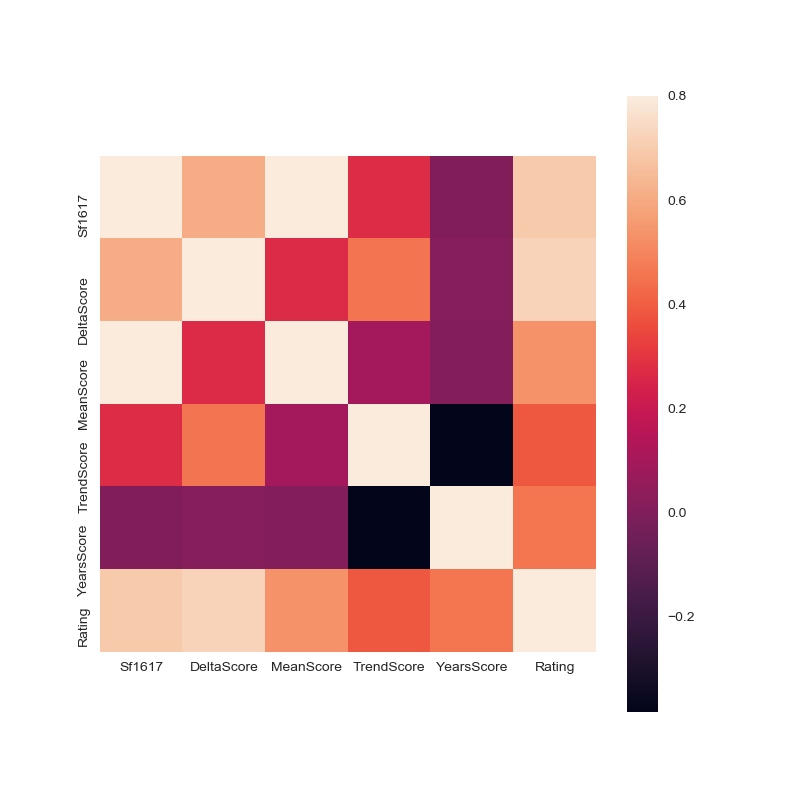

In [35]:
corrmat = dfML.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, vmax=.8, square=True)

plt.show()

<IPython.core.display.Javascript object>


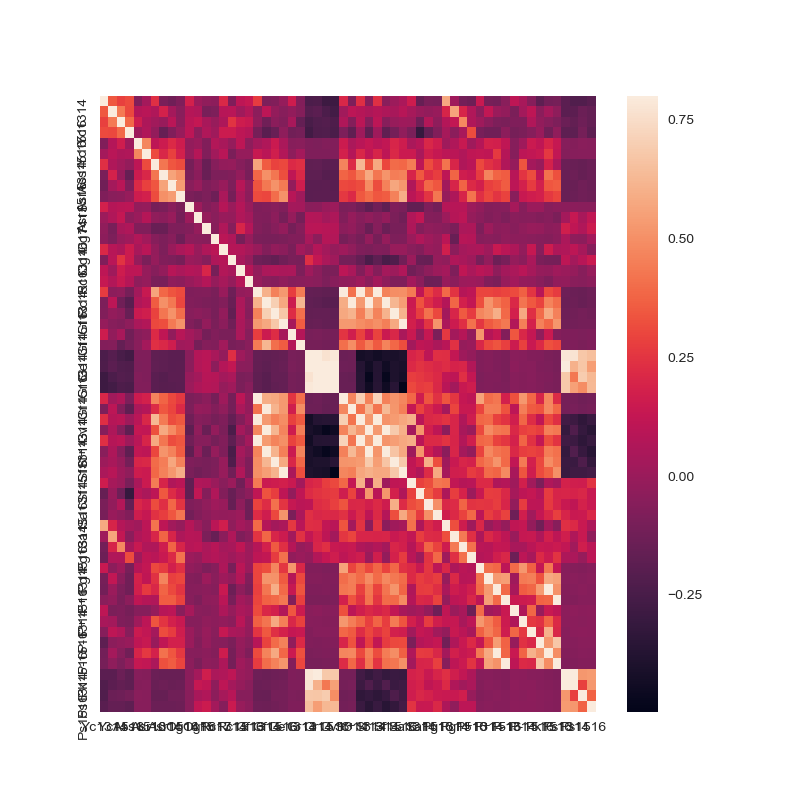

In [67]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, vmax=.8, square=False)

plt.show()

In [63]:
sns.set()
#iris = sns.dfML
sns.pairplot(dfML,  
             hue="species", palette="husl")

<IPython.core.display.Javascript object>

KeyError: 'species'

In [135]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 16 23:16:06 2019

@author: adr
"""
import math

#import pandas as pd
#df=pd.read_csv('myfile.csv', sep=',',header=None)
#df.values
#array([[ 1. ,  2. ,  3. ],
#       [ 4. ,  5.5,  6. ]])




#Przygotowanie 3 centroidow na sztywno
listaWszystkichCentroidow = list()

listaWszystkichCentroidow.append([1, 10, 2,3,4,5,6]) 
listaWszystkichCentroidow.append([999, 10, 2,3,4,5,6]) 
listaWszystkichCentroidow.append([666, 10, 2,3,4,5,6]) 

print(listaWszystkichCentroidow[1][0])


#przygotowaniepunktow w przestrzeni do testu przypisywania do centoidow
ListaWszystkichPunktow = list()

ListaWszystkichPunktow.append([1, 10, 2,3,4,5,10]) 
ListaWszystkichPunktow.append([999, 10, 2,3,4,5,10]) 
ListaWszystkichPunktow.append([666, 10, 2,3,4,5,10]) 

print(ListaWszystkichPunktow[1][0])







centroid1 = list()
centroid2 = list()
centroid3 = list()

sumDistanceToCentroid1 = 0
sumDistanceToCentroid2 = 0
sumDistanceToCentroid3 = 0

sumFinallDistance = 0

counterPoint = 0

def funkcjaCelu(ListaWszystkichCentroidow):
    pointNumber = 0
    for point in ListaWszystkichPunktow:
        centroidNumber = 0
        distance = 0
        centoidNumber = 0
        for centroid in ListaWszystkichCentroidow:
            #od wspolrzednej 0 centroidu numer 1 odejmyjemy wspolrzedna 0 punktu nr 1 itd...
            distance = (math.pow(int(ListaWszystkichCentroidow[centoidNumber][0]) - int(Lista ...
            if distance < math.sqrt(distance):
                        distance = math.sqrt(distance)
                        centroidNumber = centoidNumber
                
            #zwiekszamy licznik, bo obliczamy odleglosc od innego centroidu  
            centoidNumber = centoidNumber + 1
            
        if centroidNumber == 1:
            centroid1.append(point)
            sumDistanceToCentroid1 = sumDistanceToCentroid1 + distance
            
            
        if centroidNumber == 2:
            centroid1.append(point)
            sumDistanceToCentroid2 = sumDistanceToCentroid2 + distance
            
            
        if centroidNumber == 3:
            centroid1.append(point)
            sumDistanceToCentroid3 = sumDistanceToCentroid3 + distance
         #zwiekszamy licznik, bo znajdujemy centroid dla kolejnego punktu  
        pointNumber = pointNumber + 1
    return sumDistanceToCentroid1 + sumDistanceToCentroid2 +sumDistanceToCentroid3

funkcjaCelu(listaWszystkichCentroidow)


999
999


TypeError: pow expected 2 arguments, got 1